# Classifiction of Periodontitis

## import libraries used for the project

In [1]:
import os
import tensorflow as tf
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

c:\Users\Acapmus\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#avoid Out Of Memory (OOM) errors by setting GPU memory consumption growth
gpuSystem = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpuSystem:
    tf.config.experimental.set_memory_growth(gpu, True)

## Load and Clean Data

In [3]:
data_dir = 'data1'

In [4]:
os.listdir(data_dir)

['Non-Periodontal', 'Periodontal']

In [5]:
image_exists = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exists:
                print("image not exist list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

In [7]:
img = cv2.imread(os.path.join('data1', 'Periodontal', 'periodontal_1.png'))
img.shape


(1300, 3100, 3)

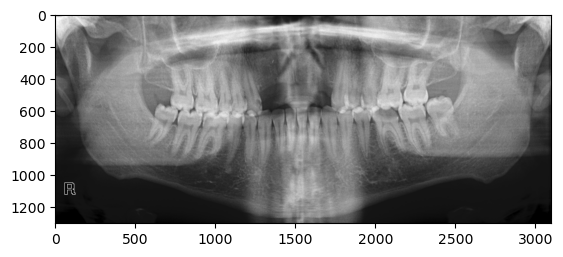

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data1', image_size=(350,350), batch_size=32)
data

Found 200 files belonging to 2 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 350, 350, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
#if run again will get another batch from the iterator
batch = data_iterator.next()

In [12]:
len(batch)

2

In [13]:
#images represented as numpy arrays
batch[0].shape

(32, 350, 350, 3)

In [14]:
#class 1 = periodontal
#class 0 = non periodontal
batch[1]

array([1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0])

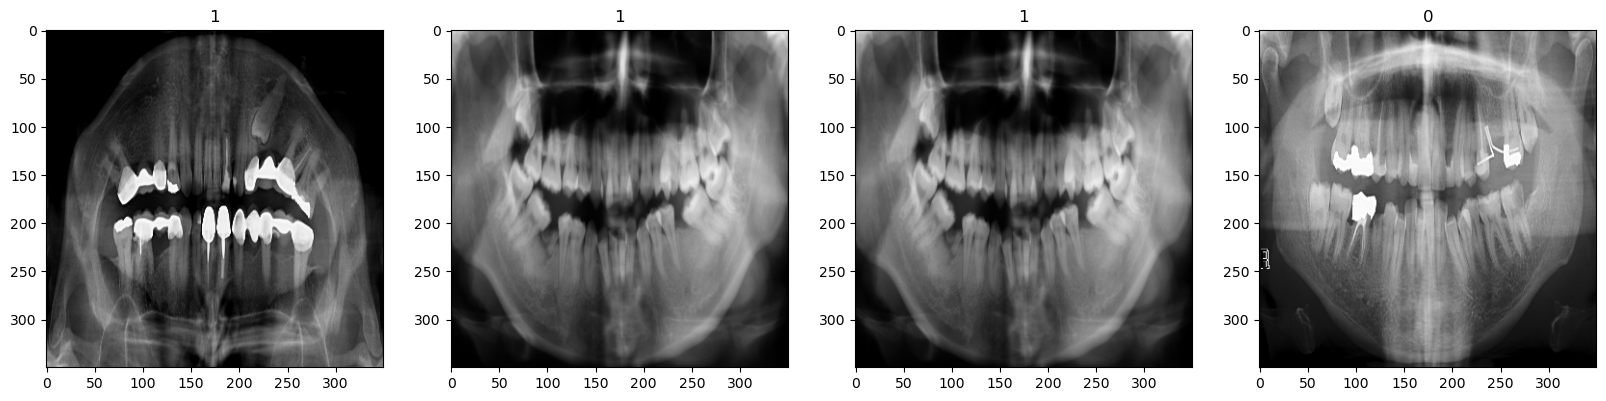

In [15]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [16]:
scaled = batch[0] / 255

In [17]:
scaled.max()

1.0

## Preprocess the Data

In [18]:
scaled_data = data.map(lambda x, y: (x/255, y))

In [19]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

In [21]:
batch[0].min()

0.0

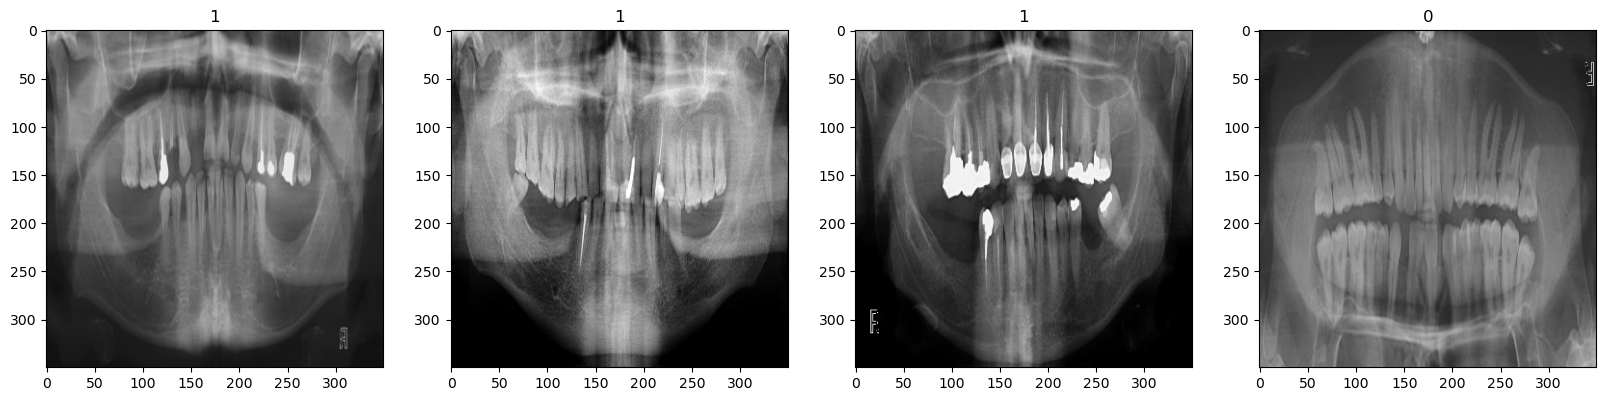

In [22]:
fig, ax = plt.subplots(ncols = 4, figsize =(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])
plt.show()

### split data

In [23]:
len(scaled_data)

7

In [24]:
#train 70%, validation 20%, test 10%
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1
train_size + val_size + test_size

7

In [25]:
train_size

4

In [26]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size).skip(val_size).take(test_size)

## Deep Model

### build deep learning model

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16,(3,3), 1, activation = 'relu', input_shape = (350,350,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation= 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [30]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 86, 86, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 42, 42, 16)       0

## train

### train the model

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [34]:
hist = model.fit(train, epochs=25, validation_data= val, callbacks= [tensorboard_callback])

Epoch 1/25
4/4 [==============================] - 7s 1s/step - loss: 1.1349 - accuracy: 0.3906 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 2/25
4/4 [==============================] - 6s 1s/step - loss: 0.6882 - accuracy: 0.5391 - val_loss: 0.6864 - val_accuracy: 0.5469
Epoch 3/25
4/4 [==============================] - 5s 1s/step - loss: 0.6896 - accuracy: 0.4766 - val_loss: 0.6811 - val_accuracy: 0.5469
Epoch 4/25
4/4 [==============================] - 5s 1s/step - loss: 0.6765 - accuracy: 0.5234 - val_loss: 0.6453 - val_accuracy: 0.6250
Epoch 5/25
4/4 [==============================] - 6s 1s/step - loss: 0.6347 - accuracy: 0.6562 - val_loss: 0.6191 - val_accuracy: 0.7656
Epoch 6/25
4/4 [==============================] - 6s 1s/step - loss: 0.5727 - accuracy: 0.7812 - val_loss: 0.5434 - val_accuracy: 0.6719
Epoch 7/25
4/4 [==============================] - 6s 1s/step - loss: 0.5588 - accuracy: 0.6719 - val_loss: 0.4528 - val_accuracy: 0.8750
Epoch 8/25
4/4 [=========================

In [35]:
hist.history

{'loss': [1.134850263595581,
  0.6882262229919434,
  0.6895943880081177,
  0.6765092015266418,
  0.6347353458404541,
  0.5726592540740967,
  0.558782160282135,
  0.4362412691116333,
  0.2869073748588562,
  0.6219491958618164,
  0.37106359004974365,
  0.40513062477111816,
  0.34677666425704956,
  0.3348943293094635,
  0.2046329379081726,
  0.20694416761398315,
  0.14659187197685242,
  0.12569451332092285,
  0.09726552665233612,
  0.03635269030928612,
  0.037611737847328186,
  0.0945584699511528,
  0.04925178736448288,
  0.06154021620750427,
  0.021746797487139702],
 'accuracy': [0.390625,
  0.5390625,
  0.4765625,
  0.5234375,
  0.65625,
  0.78125,
  0.671875,
  0.890625,
  0.9375,
  0.7578125,
  0.8515625,
  0.8359375,
  0.875,
  0.8515625,
  0.9296875,
  0.9375,
  0.9609375,
  0.953125,
  0.96875,
  0.9921875,
  0.984375,
  0.9609375,
  0.9921875,
  0.9921875,
  1.0],
 'val_loss': [0.6977049112319946,
  0.6863828897476196,
  0.6810637712478638,
  0.6453371047973633,
  0.61914205551147

### Plot Performance

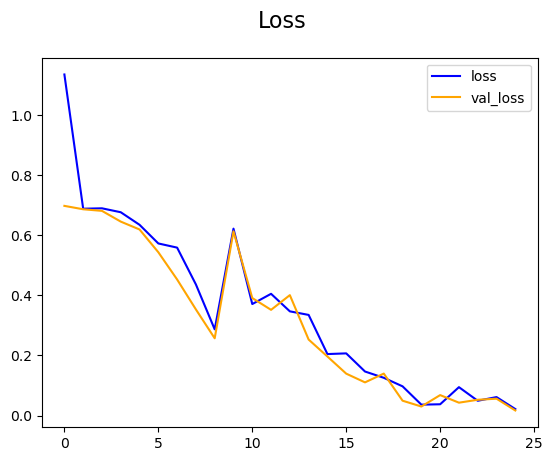

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'blue', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 16)
plt.legend(loc = 'upper right')
plt.show()

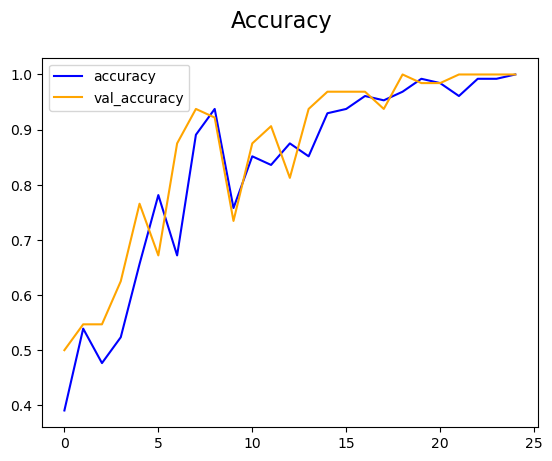

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'blue', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 16)
plt.legend(loc = 'upper left')
plt.show()

## evaluate

### evaluate the model

In [49]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [50]:
pre = Precision()
re = Recall()
Bacc = BinaryAccuracy()


In [51]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    Bacc.update_state(y, yhat)
    Acc.update_state(y,yhat)

1/1 [==============================] - 0s 54ms/step


In [52]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, BAccuracy:{Bacc.result().numpy()}')

Precision:1.0, Recall:1.0, BAccuracy:1.0, Accuracy:0.0


### test

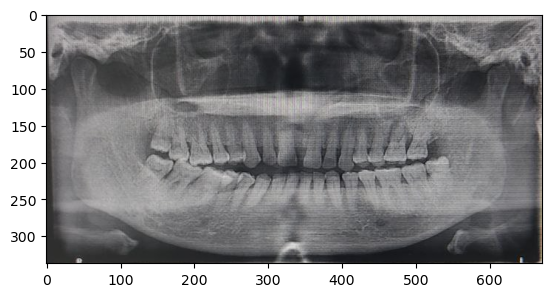

In [58]:
img = cv2.imread('peritest2.png')
imgC = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgC)
plt.show()

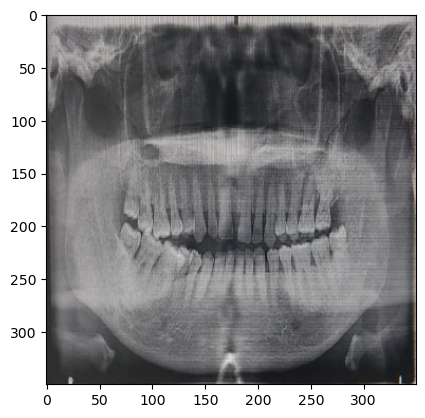

In [59]:
resize = tf.image.resize(imgC, (350,350))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [60]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 27ms/step


In [61]:
yhat

array([[0.70271087]], dtype=float32)

In [62]:
if yhat > 0.5:
    print("Predicted class is Periodontitis")
else:
    print("Predicted class is NON Periodontitis")

Predicted class is Periodontitis


## save the model

### save model

In [47]:
from tensorflow.keras.models import load_model

In [48]:
model.save(os.path.join('models', 'ClassificationPeriodontitis25epd1.h5'))